In [105]:
import pandas as pd
import numpy as np
from datetime import datetime
from datetime import timedelta 
import time
import requests
import pickle

In [106]:
## tweets dataframe
df_tweets = pd.DataFrame()

df_names = ['df_tweets_0_1000.csv',
            'df_tweets_1000_2000.csv',
            'df_tweets_2000_3000.csv',
            'df_tweets_3000_4000.csv',
            'df_tweets_4000_5000.csv',
            'df_tweets_6000_7000.csv',
            'df_tweets_5000_6000.csv',
            'df_tweets_7000_8000.csv',]

for name in df_names:
    df_tmp = pd.read_csv('csvs/' + name)
    print(len(df_tmp))
    df_tweets = df_tweets.append(df_tmp)

995
997
1000
1000
1000
1000
1000
275


In [107]:
df_tweets.head()

,color,precipIntensity,precipProbability,summary,temperature,timestamp,visibility,windSpeed
0,yellow,0.0,0.0,Partly Cloudy,47.62,2009-11-15 09:00:00,6.216,4.62
1,yellow,0.0,0.0,Partly Cloudy,50.06,2009-11-15 10:00:00,6.216,8.16
2,green,0.0,0.0,Partly Cloudy,52.58,2009-11-15 11:00:00,6.216,10.14
3,green,0.0,0.0,Partly Cloudy,54.09,2009-11-15 12:00:00,6.216,10.22
4,green,0.0,0.0,Partly Cloudy,55.15,2009-11-15 13:00:00,6.216,10.80


In [108]:
len(df_tweets)

7267

In [109]:
df_tweets_edit = df_tweets.copy()
df_tweets_edit.drop('visibility',axis=1,inplace=True)
df_tweets_edit.drop('summary',axis=1,inplace=True)
df_tweets_edit.drop('timestamp',axis=1,inplace=True)

In [110]:
df_tweets_edit.head()

,color,precipIntensity,precipProbability,temperature,windSpeed
0,yellow,0.0,0.0,47.62,4.62
1,yellow,0.0,0.0,50.06,8.16
2,green,0.0,0.0,52.58,10.14
3,green,0.0,0.0,54.09,10.22
4,green,0.0,0.0,55.15,10.80


In [111]:
df_tweets_edit['color'].unique()

array(['yellow', 'green', 'red'], dtype=object)

In [112]:
label_list = [0 if c == 'green' else 1 for c in df_tweets_edit['color']]
df_tweets_edit['label'] = label_list
df_tweets_final = df_tweets_edit.copy()
df_tweets_final.drop('color',axis=1,inplace=True)

In [113]:
df_tweets_final.head()

,precipIntensity,precipProbability,temperature,windSpeed,label
0,0.0,0.0,47.62,4.62,1
1,0.0,0.0,50.06,8.16,1
2,0.0,0.0,52.58,10.14,0
3,0.0,0.0,54.09,10.22,0
4,0.0,0.0,55.15,10.80,0


In [114]:
# df from data gen
df_data_gen = pd.read_csv('csvs/df.csv',index_col=0)
df_data_gen.head()

,precipIntensity,precipProbability,temperature,windSpeed,label
0,0.0,0.0,41.24,22.44,1
1,0.0,0.0,41.28,26.34,1
2,0.0,0.0,41.14,22.56,1
3,0.0,0.0,42.95,23.52,1
4,0.0,0.0,42.91,23.65,1


In [115]:
# merge
df = pd.merge(df_data_gen,df_tweets_final,how='outer')
df.head()

,precipIntensity,precipProbability,temperature,windSpeed,label
0,0.0,0.0,41.24,22.44,1
1,0.0,0.0,41.28,26.34,1
2,0.0,0.0,41.14,22.56,1
3,0.0,0.0,42.95,23.52,1
4,0.0,0.0,42.91,23.65,1


In [116]:
df['windSpeed'].idxmax()

10

In [117]:
df.iloc[10]

precipIntensity       0.00
precipProbability     0.00
temperature          47.07
windSpeed            66.11
label                 1.00
Name: 10, dtype: float64

In [118]:
import matplotlib.pyplot as plt

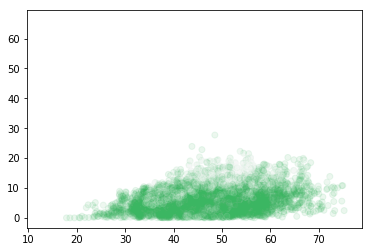

In [119]:
x = df['temperature']
y = df['windSpeed']

color_list = ['#ea4e0b' if l==1 else 'white' for l in df['label']]
color_list = ['white' if l==1 else '#3bb662' for l in df['label']]

plt.scatter(x,y,alpha=.1, c=color_list)

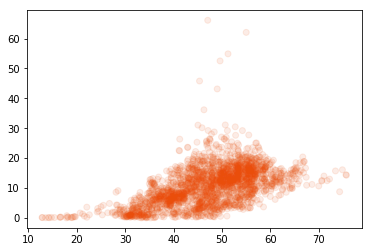

In [120]:
x = df.where(df['label']==1)['temperature']
y = df.where(df['label']==1)['windSpeed']

color_list = ['#ea4e0b' if l==1 else 'white' for l in df['label']]
#color_list = ['white' if l==1 else '#3bb662' for l in df['label']]

plt.scatter(x,y,alpha=.1, c=color_list)

In [152]:
from sklearn.model_selection import train_test_split
from sklearn import linear_model
from sklearn import metrics
from sklearn import svm

In [307]:
# make train/test

x = df.drop('label',axis=1)
y = df['label']
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=.33) #, random_state=2)

In [533]:
logistic = linear_model.LogisticRegression()

w_svm_linear = svm.SVC(kernel='linear', class_weight={1: 2}, probability=True)
w_svm_rbf = svm.SVC(kernel='rbf', class_weight={1: 2}, probability=True, gamma=.01)

model = w_svm_linear

In [534]:
model.fit(x_train, y_train)

y_pred = model.predict(x_test)

In [535]:
acc = metrics.accuracy_score(y_test,y_pred)
print(f'accuracy = {acc}')

recall = metrics.recall_score(y_test,y_pred)
print(f'recall = {recall}')

precision = metrics.precision_score(y_test,y_pred)
print(f'precision = {precision}')


accuracy = 0.7476423990946812
recall = 0.5198412698412699
precision = 0.5622317596566524


In [536]:
1 / (y_train.sum()/len(y_train))

3.7335183900069397

In [537]:
print(f'{y_pred.sum()} class 1 prediction compared to {y_test.sum()} in the test set out of {len(y_test)} total')

699 class 1 prediction compared to 756 in the test set out of 2651 total


## Decision boundary

In [538]:
print(x_test.iloc[0],y_test.iloc[0])

precipIntensity       0.00
precipProbability     0.00
temperature          48.16
windSpeed             3.13
Name: 7608, dtype: float64 1


In [539]:
model.predict_proba(np.array(x_test.iloc[1]).reshape(-1,4))

array([[0.81111534, 0.18888466]])

In [540]:
def get_prediction(x_list):
    x_to_pred = np.array(x_list).reshape(-1,4)
    print(x_to_pred)
    return model.predict_proba(x_to_pred)

In [541]:
x_to_pred = np.array([0,0,0,0])
get_prediction(x_to_pred)

[[0 0 0 0]]


array([[0.70312355, 0.29687645]])

In [542]:
precipIntensity = 0
precipProbability = 1
temperature = 55
windSpeed = 5
x_to_pred = np.array([precipIntensity,precipProbability,temperature,windSpeed])
get_prediction(x_to_pred)

[[ 0  1 55  5]]


array([[0.90681652, 0.09318348]])

In [543]:
#model.coef_

In [544]:
# Plotting decision regions
# x is temperature
# y is windSpeed
# precipProbability and precipProbability held constant at 0

resolution = 100
x_min, x_max = x['temperature'].min() - 1, x['temperature'].max() + 1
y_min, y_max = x['windSpeed'].min() - 1, x['windSpeed'].max() + 1

const_1 = np.arange(0, .01, 0.1)
const_2 = np.arange(1, 1.01, 0.1)
xx = np.linspace(x_min, x_max, resolution)
yy = np.linspace(y_min, y_max, resolution)
C1, C2, YY, XX = np.meshgrid(const_1, const_2, yy, xx)
xy = np.vstack([C1.ravel(), C2.ravel(), XX.ravel(), YY.ravel()]).T

z = model.predict_proba(xy)[:,1].reshape(resolution,resolution)

In [545]:
#model.predict_proba(xy)[:,1][0]

In [546]:
#z.max()

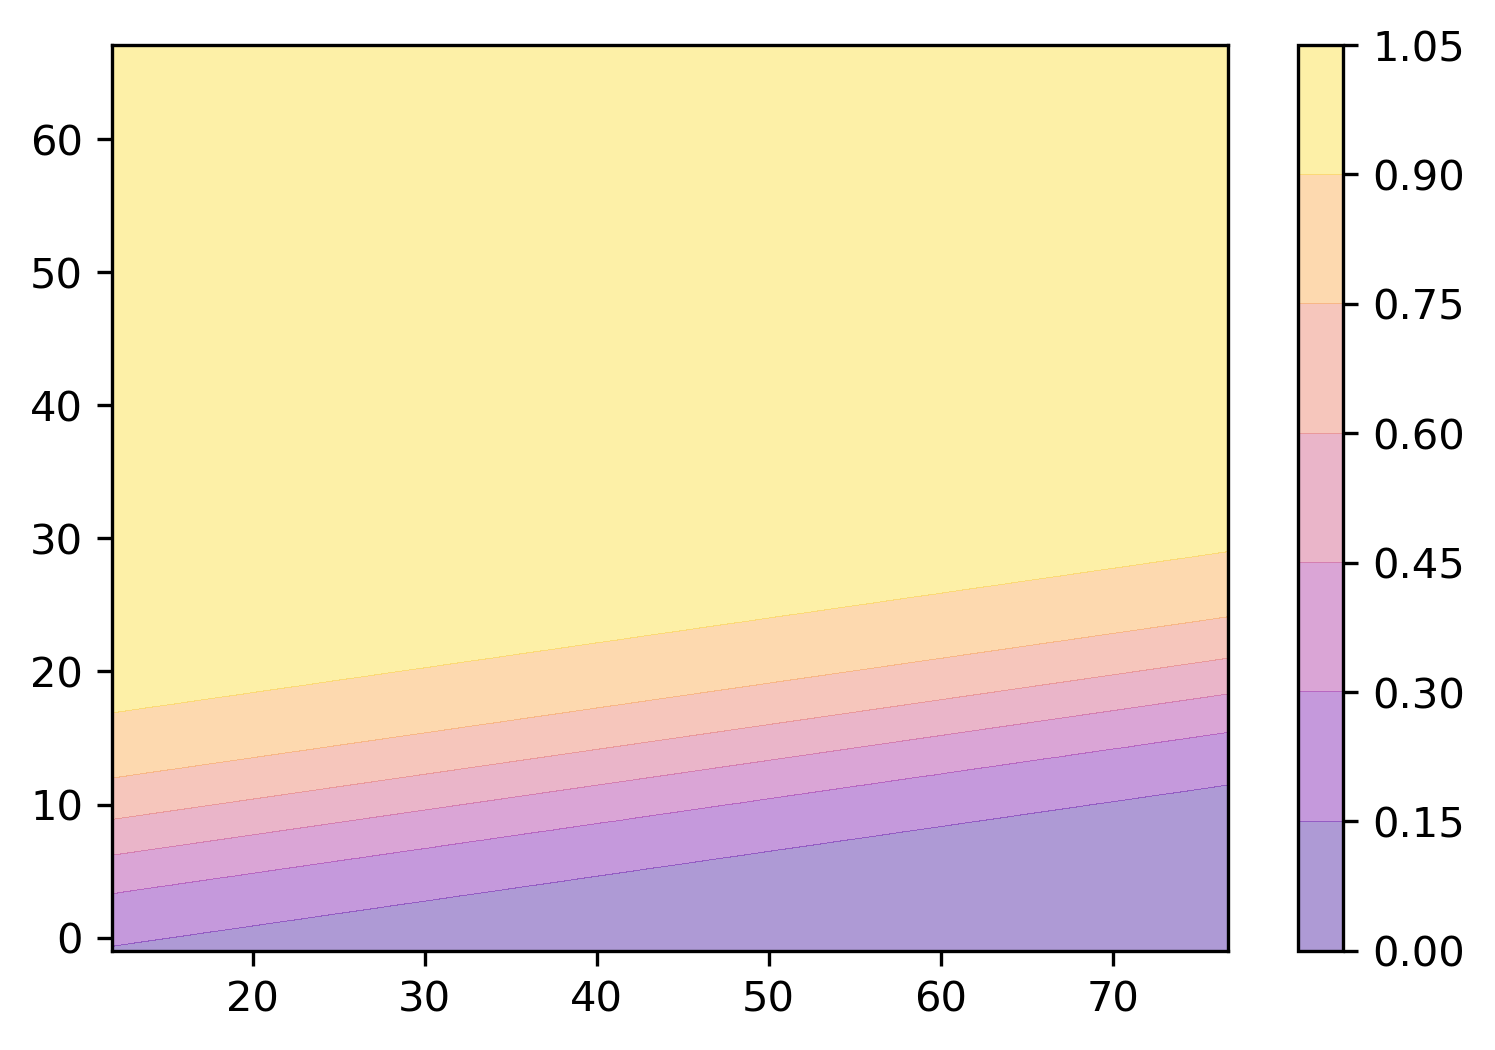

In [548]:
fig1 = plt.figure(figsize=(6,4),dpi=300)
ax = plt.gca()
cs = ax.contourf(xx, yy, z, alpha=0.4,cmap=plt.cm.plasma)
fig1 = plt.gcf()
cbar = fig1.colorbar(cs)

